In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#/content/drive/MyDrive/project/flickr8k/Images

In [ ]:
#image_path = '/content/drive/MyDrive/project/flickr8k/Images'
image_path = '/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images'

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/captions.txt")
#data = pd.read_csv("/content/drive/MyDrive/project/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

Visulization


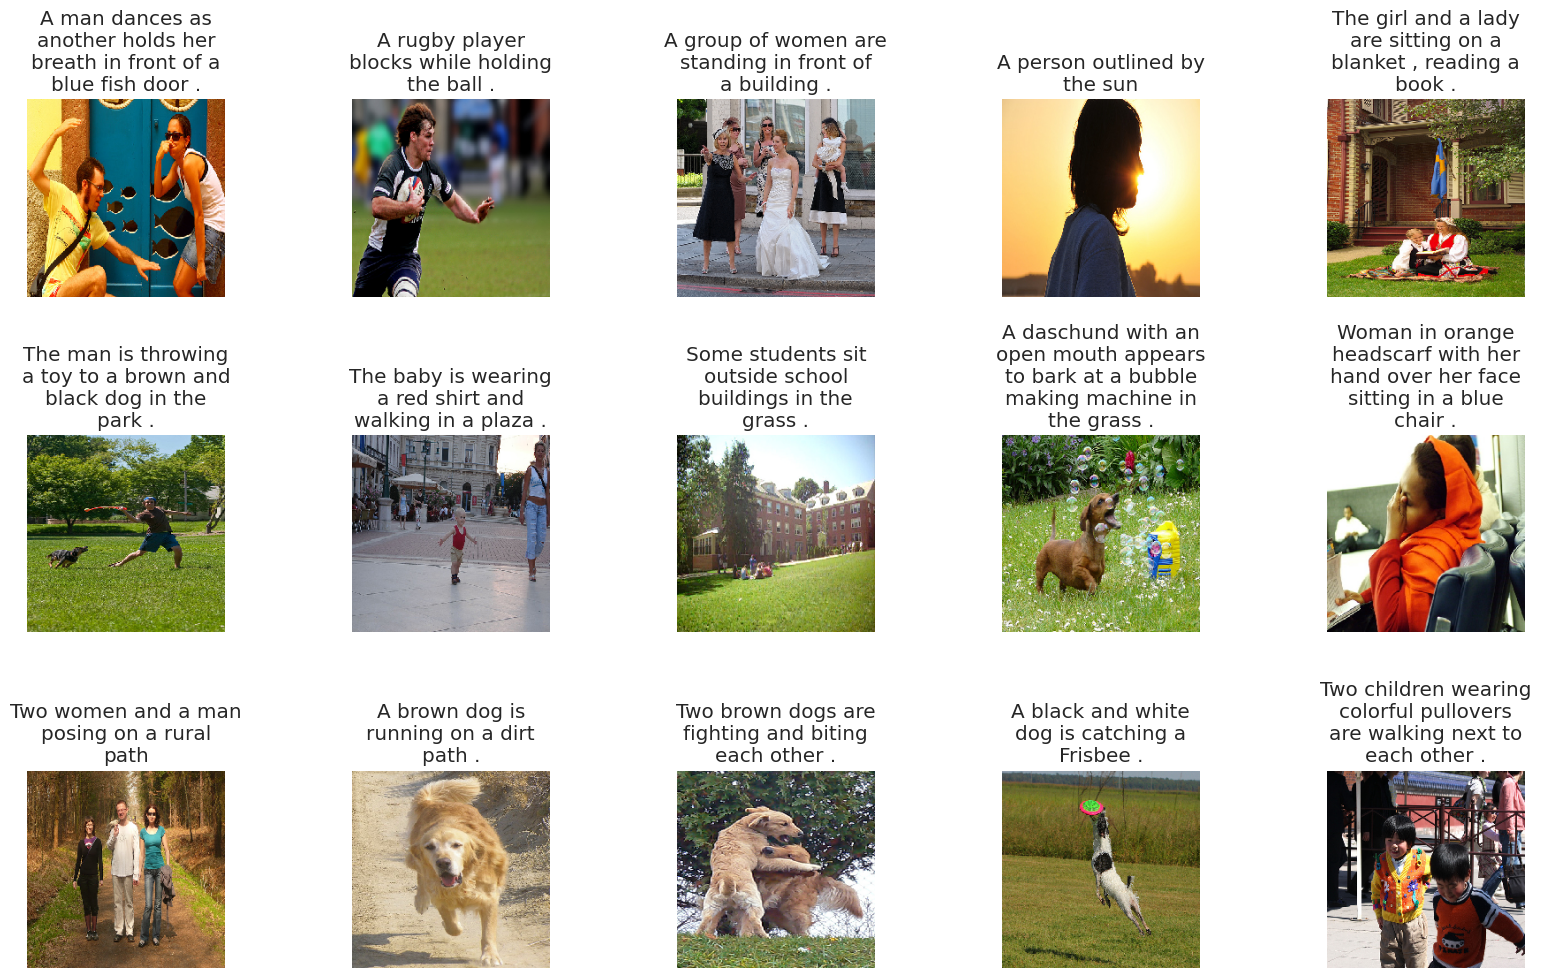

In [ ]:
display_images(data.sample(15))

Caption Text Preprocessing Steps

1.   Convert sentences into lowercase

2.   Remove special characters and numbers present in the text

3.   Remove extra spaces

4.   Remove single characters

5.   Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

Preprocessed Text

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

Tokenization and Encoded Representation


1.   The words in a sentence are separated/tokenized and encoded in a one hot representation
2.   These encodings are then passed to the embeddings layer to generate word embeddings



In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

Model


In [ ]:
model = VGG16()
fe = Model(inputs=model.input, outputs=model.layers[-3].output)
fe.summary()
img_size = 224
features = {}

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#model = ResNet50()# change from DenseNet 201 to Resnet 50

for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [1:15:40<00:00,  1.78it/s]


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/VGG16_cnn+lstm/VGG16_cnn_lstms_feature_data.pkl', 'wb') as fp:
    pickle.dump(features, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [ ]:
"""import pickle
with open('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/VGG16_cnn+lstm/VGG16_cnn_lstms_feature_data.pkl', 'rb') as fp:
  features = pickle.load(fp)"""

"import pickle\nwith open('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/VGG16_cnn+lstm/VGG16_cnn_lstms_feature_data.pkl', 'rb') as fp:\n  features = pickle.load(fp)"

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

## Modelling




In [ ]:
#input1 = Input(shape=(1920,)) Densenet 201
#input1 = Input(shape=(2048,)) # Resnet 50
input1 = Input(shape=(4096,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
from tensorflow.keras.utils import plot_model

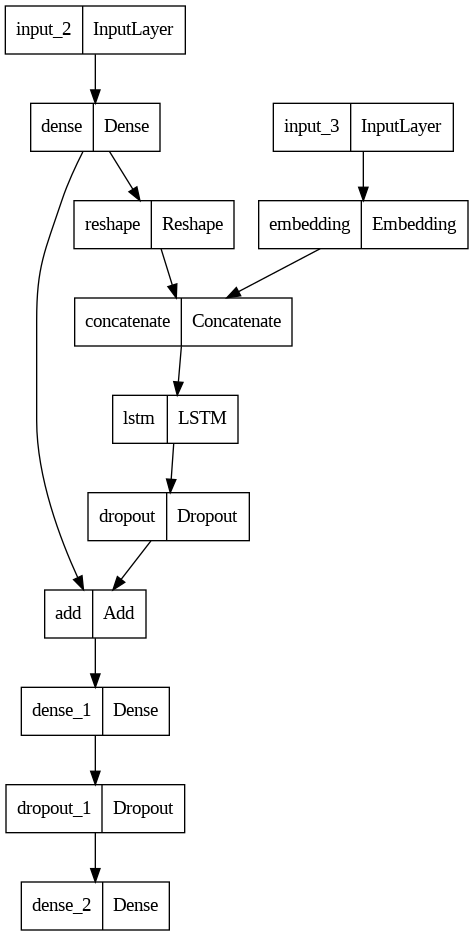

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          1048832     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

Training

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 5.1838
Epoch 1: val_loss improved from inf to 4.38031, saving model to model.h5
537/537 [==============================] - 213s 387ms/step - loss: 5.1838 - val_loss: 4.3803 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.3739
Epoch 2: val_loss improved from 4.38031 to 4.10356, saving model to model.h5
537/537 [==============================] - 49s 91ms/step - loss: 4.3739 - val_loss: 4.1036 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 4.1304
Epoch 3: val_loss improved from 4.10356 to 3.92986, saving model to model.h5
537/537 [==============================] - 39s 73ms/step - loss: 4.1304 - val_loss: 3.9299 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.9717
Epoch 4: val_loss improved from 3.92986 to 3.85050, saving model to model.h5
537/537 [==============================] - 38s 72ms/step - loss: 3.9717 - 

In [ ]:
caption_model.save('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/VGG16_cnn+lstm/VGG16_CNNS+LSTMS_model.h5') # save model

In [ ]:
#caption_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/VGG16_cnn+lstm/VGG16_CNNS+LSTMS_model.h5')

## Caption Generation Utility Functions



1.   Utility functions to generate the captions of input images at the inference time.
2.   Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word




In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

Taking 15 Random Samples for Caption Prediction


In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
def display_generated_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.new_caption[i], 20)))
        plt.axis("off")

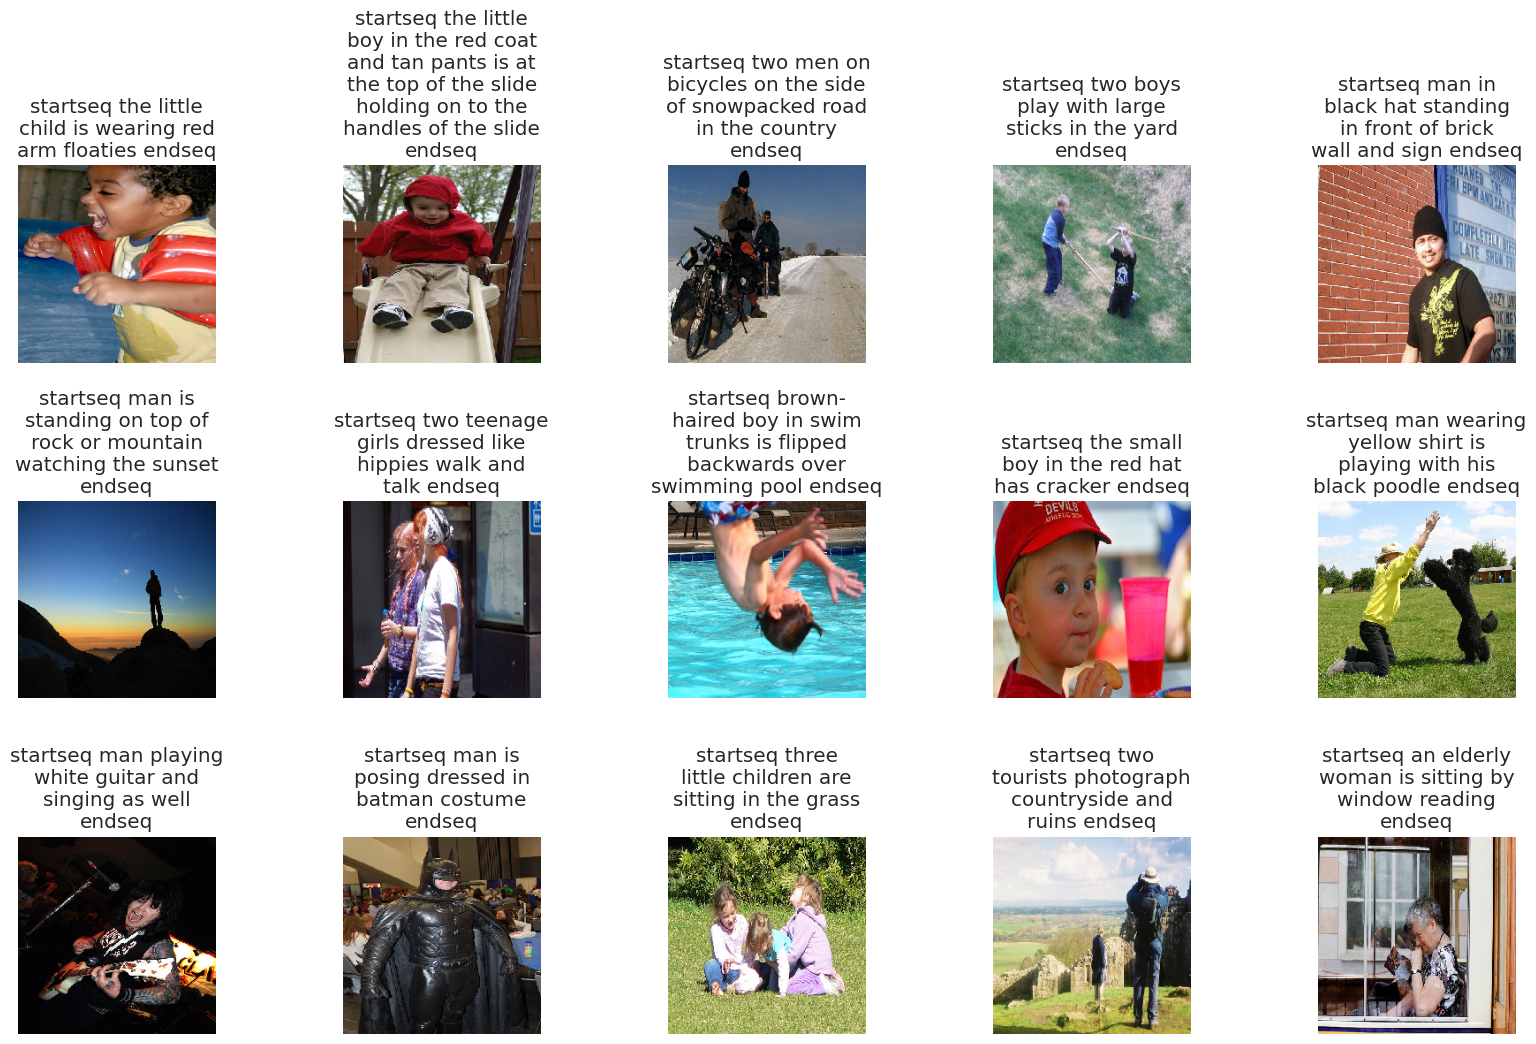

In [ ]:
display_images(samples)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    #samples.loc[index,'caption'] = caption
    samples.loc[index,'new_caption'] = caption

1/1 [==============================] - 0s 18ms/step


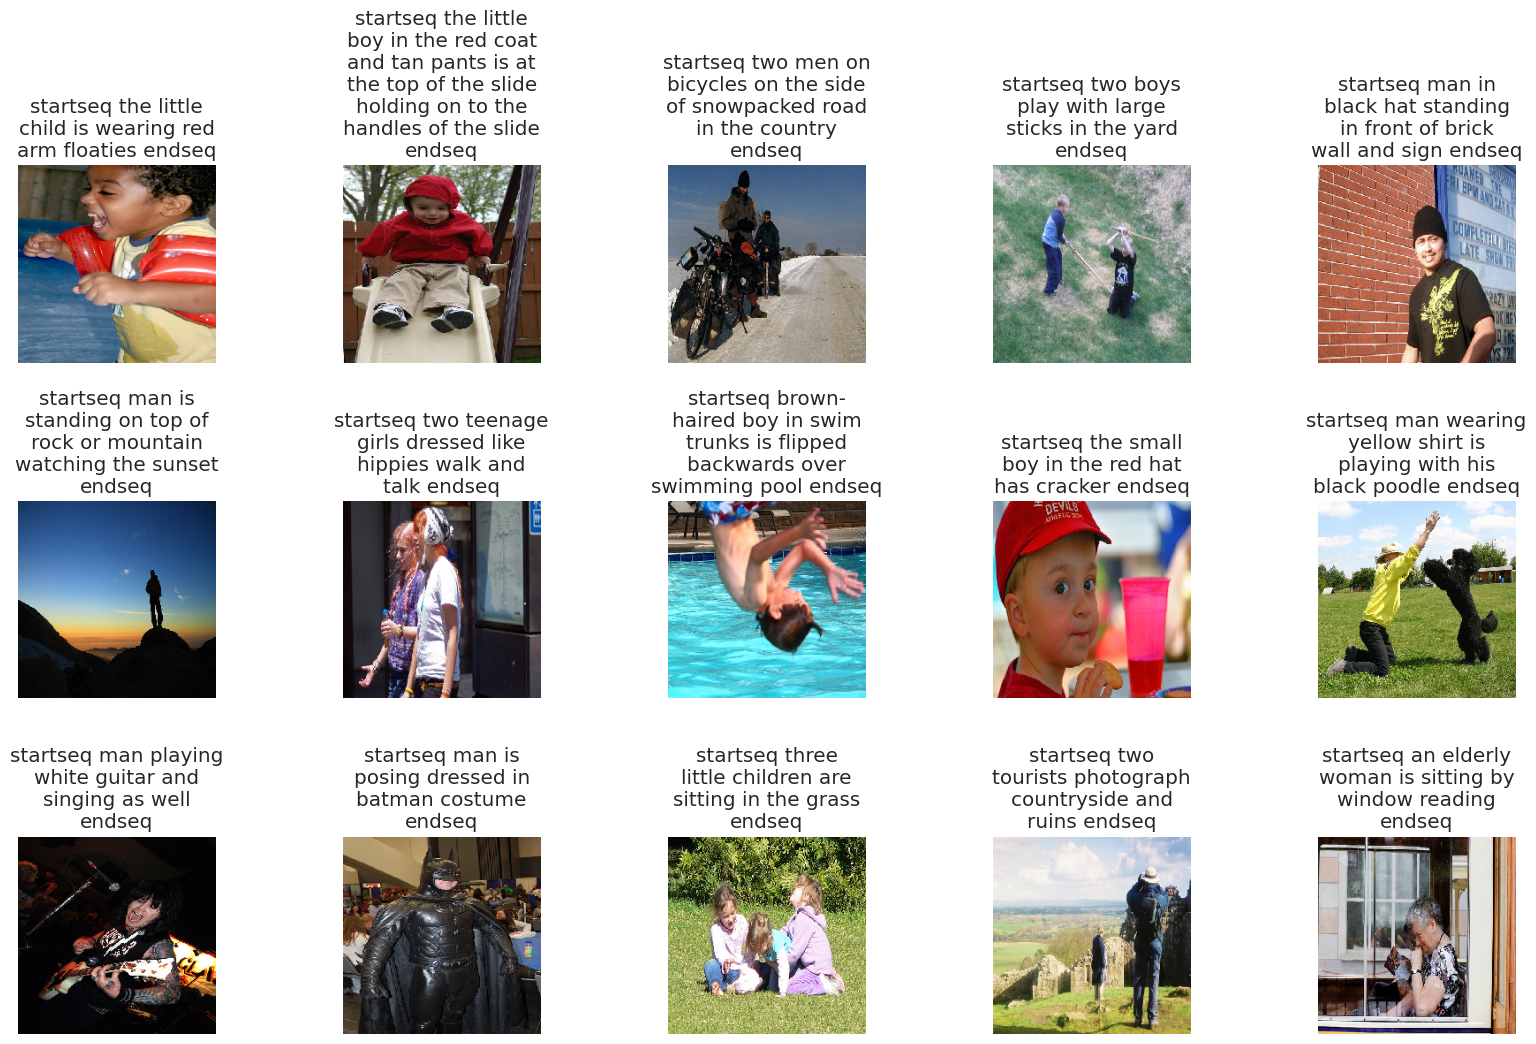

In [ ]:
display_images(samples)

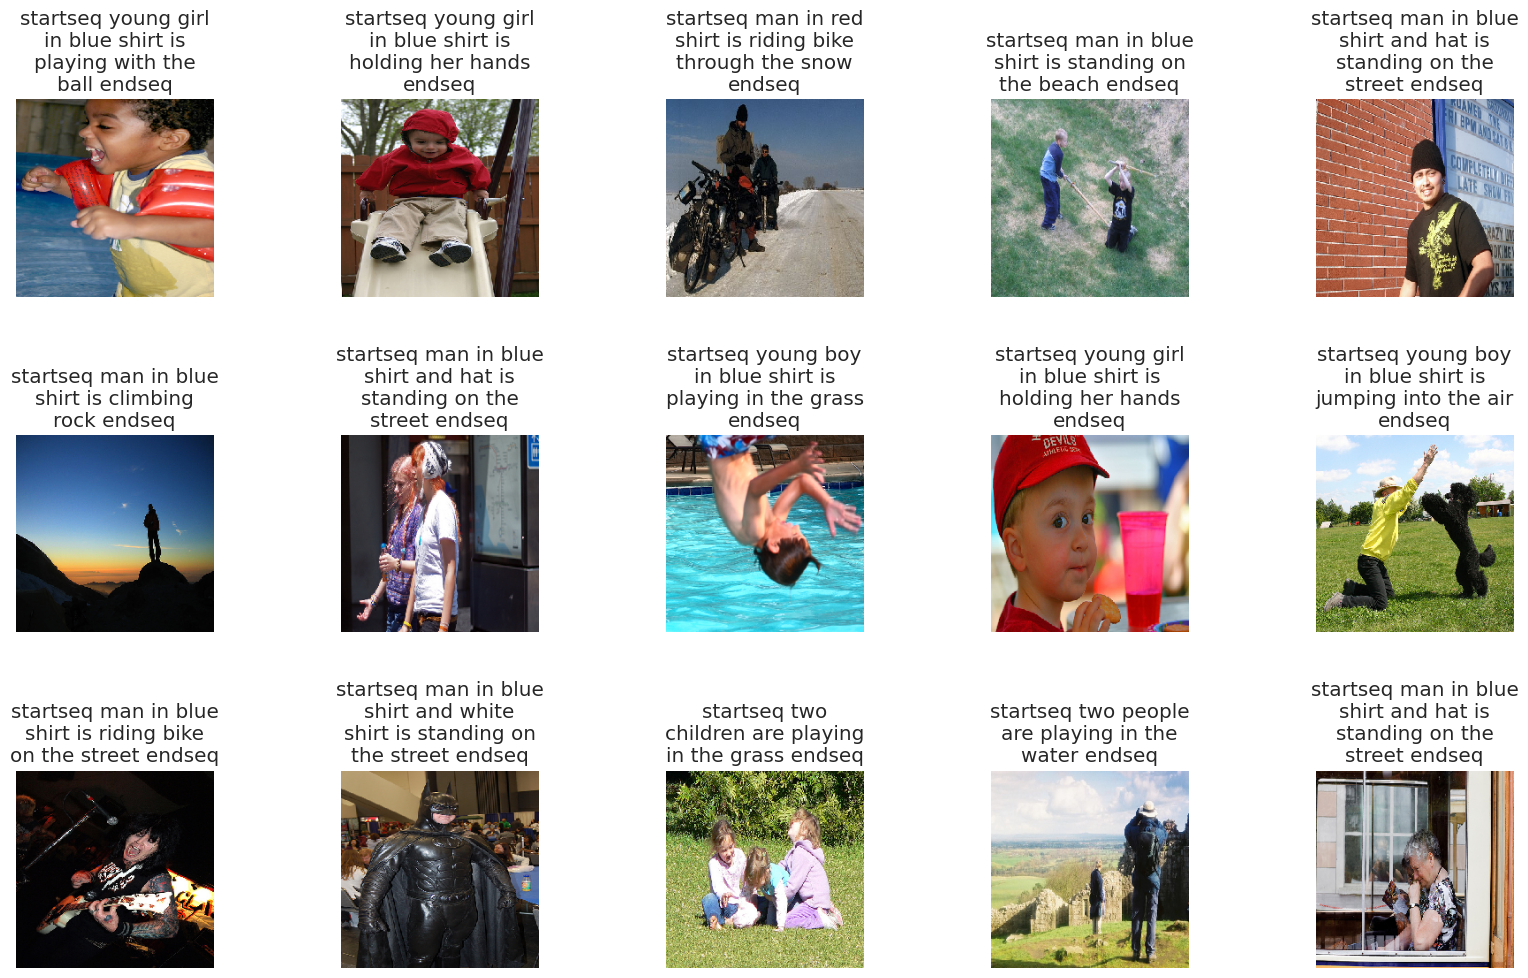

In [ ]:
display_generated_images(samples)

In [ ]:
samples

image  \
0    578274277_652cae32ba.jpg   
1    549520317_af3d5c32eb.jpg   
2     95734035_84732a92c1.jpg   
3    639865690_d66d480879.jpg   
4    421730441_6b2267fd31.jpg   
5     58368365_03ed3e5bdf.jpg   
6    862156271_3eacea90a8.jpg   
7    519059913_4906fe4050.jpg   
8    688940111_325a74674a.jpg   
9    427082246_5bf1c3676f.jpg   
10  3697379772_40d831392b.jpg   
11   416650559_cd08d3cd96.jpg   
12   368954110_821ccf005c.jpg   
13   429283612_37f6e7fb7f.jpg   
14  3726590391_bc6e729bb6.jpg   

                                              caption  \
0   startseq the little child is wearing red arm f...   
1   startseq the little boy in the red coat and ta...   
2   startseq two men on bicycles on the side of sn...   
3   startseq two boys play with large sticks in th...   
4   startseq man in black hat standing in front of...   
5   startseq man is standing on top of rock or mou...   
6   startseq two teenage girls dressed like hippie...   
7   startseq brown-haired boy in swim trunks is fl...   
8   startseq the small boy in the red hat has crac...   
9   startseq man wearing yellow shirt is playing w...   
10  startseq man playing white guitar and singing ...   
11  startseq man is posing dressed in batman costu...   
12  startseq three little children are sitting in ...   
13  startseq two tourists photograph countryside a...   
14  startseq an elderly woman is sitting by window...   

                                          new_caption  
0   startseq young girl in blue shirt is playing w...  
1   startseq young girl in blue shirt is holding h...  
2   startseq man in red shirt is riding bike throu...  
3   startseq man in blue shirt is standing on the ...  
4   startseq man in blue shirt and hat is standing...  
5   startseq man in blue shirt is climbing rock en...  
6   startseq man in blue shirt and hat is standing...  
7   startseq young boy in blue shirt is playing in...  
8   startseq young girl in blue shirt is holding h...  
9   startseq young boy in blue shirt is jumping in...  
10  startseq man in blue shirt is riding bike on t...  
11  startseq man in blue shirt and white shirt is ...  
12  startseq two children are playing in the grass...  
13  startseq two people are playing in the water e...  
14  startseq man in blue shirt and hat is standing...

Evaluations:

In [ ]:
Test_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/15_percent_test_set.csv")
Test_set

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              1  3688858505_e8afd1475d.jpg   
2              2  3688858505_e8afd1475d.jpg   
3              3  3688858505_e8afd1475d.jpg   
4              4  3688858505_e8afd1475d.jpg   
...          ...                        ...   
6065        6065   997722733_0cb5439472.jpg   
6066        6066   997722733_0cb5439472.jpg   
6067        6067   997722733_0cb5439472.jpg   
6068        6068   997722733_0cb5439472.jpg   
6069        6069   997722733_0cb5439472.jpg   

                                                caption  
0     startseq blond girl in green dress and elabora...  
1     startseq few people with girl standing up in t...  
2              startseq girl is wear green dress endseq  
3     startseq blonde girl wearing green dress stand...  
4     startseq woman in green dress being observed e...  
...                                                 ...  
6065  startseq man in pink shirt climbs rock face en...  
6066  startseq man is rock climbing high in the air ...  
6067  startseq person in red shirt climbing up rock ...  
6068          startseq rock climber in red shirt endseq  
6069  startseq rock climber practices on rock climbi...  

[6070 rows x 3 columns]

In [ ]:
test_dataset = pd.DataFrame()
for index,record in Test_set.iterrows():
  if index%5 == 0:
    #df2 = pd.concat([new_row,df.loc[:]]).reset_index(drop=True)
    test_dataset = test_dataset.append(record,ignore_index=True)
test_dataset.reset_index(drop=True,inplace=True)
test_dataset

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              5  3689355450_fd559b816d.jpg   
2             10   368954110_821ccf005c.jpg   
3             15  3689727848_b53f931130.jpg   
4             20  3689975998_72f50b6d91.jpg   
...          ...                        ...   
1209        6045   990890291_afc72be141.jpg   
1210        6050    99171998_7cc800ceef.jpg   
1211        6055    99679241_adc853a5c0.jpg   
1212        6060   997338199_7343367d7f.jpg   
1213        6065   997722733_0cb5439472.jpg   

                                                caption  
0     startseq blond girl in green dress and elabora...  
1     startseq boy wearing plaid shorts jumping over...  
2     startseq girl in purple top holds toddler betw...  
3     startseq boy tries to catch ball while jumping...  
4      startseq an asian girl is running outside endseq  
...                                                 ...  
1209  startseq man does wheelie on his bicycle on th...  
1210  startseq group is sitting around snowy crevass...  
1211  startseq grey bird stands majestically on beac...  
1212    startseq person stands near golden walls endseq  
1213  startseq man in pink shirt climbs rock face en...  

[1214 rows x 3 columns]

In [ ]:
for index,record in test_dataset.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    #print(caption)
    test_dataset.loc[index,'new_caption'] = caption

流式输出内容被截断，只能显示最后 5000 行内容。
1/1 [==============================] - 0s 26ms/step


In [ ]:
for index,record in test_dataset.iterrows():
  for i in range(0,5):
    Test_set.loc[index*5+i,"new_caption"] = record["new_caption"]

Test_set

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              1  3688858505_e8afd1475d.jpg   
2              2  3688858505_e8afd1475d.jpg   
3              3  3688858505_e8afd1475d.jpg   
4              4  3688858505_e8afd1475d.jpg   
...          ...                        ...   
6065        6065   997722733_0cb5439472.jpg   
6066        6066   997722733_0cb5439472.jpg   
6067        6067   997722733_0cb5439472.jpg   
6068        6068   997722733_0cb5439472.jpg   
6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     startseq blond girl in green dress and elabora...   
1     startseq few people with girl standing up in t...   
2              startseq girl is wear green dress endseq   
3     startseq blonde girl wearing green dress stand...   
4     startseq woman in green dress being observed e...   
...                                                 ...   
6065  startseq man in pink shirt climbs rock face en...   
6066  startseq man is rock climbing high in the air ...   
6067  startseq person in red shirt climbing up rock ...   
6068          startseq rock climber in red shirt endseq   
6069  startseq rock climber practices on rock climbi...   

                                            new_caption  
0     startseq man in blue shirt is standing on the ...  
1     startseq man in blue shirt is standing on the ...  
2     startseq man in blue shirt is standing on the ...  
3     startseq man in blue shirt is standing on the ...  
4     startseq man in blue shirt is standing on the ...  
...                                                 ...  
6065  startseq man in blue shirt is riding bike thro...  
6066  startseq man in blue shirt is riding bike thro...  
6067  startseq man in blue shirt is riding bike thro...  
6068  startseq man in blue shirt is riding bike thro...  
6069  startseq man in blue shirt is riding bike thro...  

[6070 rows x 4 columns]

In [ ]:
Test_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/VGG16_cnn+lstm/Test_set_sim.csv")

In [ ]:
Test_set

Unnamed: 0.1  Unnamed: 0                      image  \
0                0           0  3688858505_e8afd1475d.jpg   
1                1           1  3688858505_e8afd1475d.jpg   
2                2           2  3688858505_e8afd1475d.jpg   
3                3           3  3688858505_e8afd1475d.jpg   
4                4           4  3688858505_e8afd1475d.jpg   
...            ...         ...                        ...   
6065          6065        6065   997722733_0cb5439472.jpg   
6066          6066        6066   997722733_0cb5439472.jpg   
6067          6067        6067   997722733_0cb5439472.jpg   
6068          6068        6068   997722733_0cb5439472.jpg   
6069          6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     startseq blond girl in green dress and elabora...   
1     startseq few people with girl standing up in t...   
2              startseq girl is wear green dress endseq   
3     startseq blonde girl wearing green dress stand...   
4     startseq woman in green dress being observed e...   
...                                                 ...   
6065  startseq man in pink shirt climbs rock face en...   
6066  startseq man is rock climbing high in the air ...   
6067  startseq person in red shirt climbing up rock ...   
6068          startseq rock climber in red shirt endseq   
6069  startseq rock climber practices on rock climbi...   

                                            new_caption  sim_score  
0     startseq man in blue shirt is standing on the ...     0.2970  
1     startseq man in blue shirt is standing on the ...     0.3505  
2     startseq man in blue shirt is standing on the ...     0.3171  
3     startseq man in blue shirt is standing on the ...     0.3267  
4     startseq man in blue shirt is standing on the ...     0.3996  
...                                                 ...        ...  
6065  startseq man in blue shirt is riding bike thro...     0.4259  
6066  startseq man in blue shirt is riding bike thro...     0.4788  
6067  startseq man in blue shirt is riding bike thro...     0.3993  
6068  startseq man in blue shirt is riding bike thro...     0.4777  
6069  startseq man in blue shirt is riding bike thro...     0.4265  

[6070 rows x 6 columns]

In [ ]:
Test_set['caption'] = Test_set['caption'].str.replace('startseq', '')
Test_set['caption'] = Test_set['caption'].str.replace('endseq', '')
Test_set['caption'] = Test_set['caption'].str.strip()

Test_set['new_caption'] = Test_set['new_caption'].str.replace('startseq', '')
Test_set['new_caption'] = Test_set['new_caption'].str.replace('endseq', '')
Test_set['new_caption'] = Test_set['new_caption'].str.strip()
Test_set = Test_set.drop(columns=['sim_score'])
Test_set

Unnamed: 0.1  Unnamed: 0                      image  \
0                0           0  3688858505_e8afd1475d.jpg   
1                1           1  3688858505_e8afd1475d.jpg   
2                2           2  3688858505_e8afd1475d.jpg   
3                3           3  3688858505_e8afd1475d.jpg   
4                4           4  3688858505_e8afd1475d.jpg   
...            ...         ...                        ...   
6065          6065        6065   997722733_0cb5439472.jpg   
6066          6066        6066   997722733_0cb5439472.jpg   
6067          6067        6067   997722733_0cb5439472.jpg   
6068          6068        6068   997722733_0cb5439472.jpg   
6069          6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     blond girl in green dress and elaborate gold n...   
1     few people with girl standing up in the center...   
2                              girl is wear green dress   
3              blonde girl wearing green dress standing   
4                   woman in green dress being observed   
...                                                 ...   
6065                 man in pink shirt climbs rock face   
6066               man is rock climbing high in the air   
6067  person in red shirt climbing up rock face cove...   
6068                          rock climber in red shirt   
6069       rock climber practices on rock climbing wall   

                                            new_caption  
0           man in blue shirt is standing on the street  
1           man in blue shirt is standing on the street  
2           man in blue shirt is standing on the street  
3           man in blue shirt is standing on the street  
4           man in blue shirt is standing on the street  
...                                                 ...  
6065  man in blue shirt is riding bike through the snow  
6066  man in blue shirt is riding bike through the snow  
6067  man in blue shirt is riding bike through the snow  
6068  man in blue shirt is riding bike through the snow  
6069  man in blue shirt is riding bike through the snow  

[6070 rows x 5 columns]

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=d207383ce2be8a40332ff65abddf1defe9a57225f58907011876904775618128
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer, util
lan_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
for index,record in Test_set.iterrows():
  sentences = []
  sentences.append(record["caption"])
  sentences.append(record["new_caption"])
  #print(sentences)
  embeddings = lan_model.encode(sentences)
  sim = util.cos_sim(embeddings[0], embeddings[1])
  Test_set.loc[index,'sim_score'] = round(sim.tolist()[0][0],4)
Test_set

Unnamed: 0.1  Unnamed: 0                      image  \
0                0           0  3688858505_e8afd1475d.jpg   
1                1           1  3688858505_e8afd1475d.jpg   
2                2           2  3688858505_e8afd1475d.jpg   
3                3           3  3688858505_e8afd1475d.jpg   
4                4           4  3688858505_e8afd1475d.jpg   
...            ...         ...                        ...   
6065          6065        6065   997722733_0cb5439472.jpg   
6066          6066        6066   997722733_0cb5439472.jpg   
6067          6067        6067   997722733_0cb5439472.jpg   
6068          6068        6068   997722733_0cb5439472.jpg   
6069          6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     blond girl in green dress and elaborate gold n...   
1     few people with girl standing up in the center...   
2                              girl is wear green dress   
3              blonde girl wearing green dress standing   
4                   woman in green dress being observed   
...                                                 ...   
6065                 man in pink shirt climbs rock face   
6066               man is rock climbing high in the air   
6067  person in red shirt climbing up rock face cove...   
6068                          rock climber in red shirt   
6069       rock climber practices on rock climbing wall   

                                            new_caption  sim_score  
0           man in blue shirt is standing on the street     0.2620  
1           man in blue shirt is standing on the street     0.3630  
2           man in blue shirt is standing on the street     0.2580  
3           man in blue shirt is standing on the street     0.3001  
4           man in blue shirt is standing on the street     0.2368  
...                                                 ...        ...  
6065  man in blue shirt is riding bike through the snow     0.5141  
6066  man in blue shirt is riding bike through the snow     0.5226  
6067  man in blue shirt is riding bike through the snow     0.4163  
6068  man in blue shirt is riding bike through the snow     0.3876  
6069  man in blue shirt is riding bike through the snow     0.3214  

[6070 rows x 6 columns]

In [ ]:
Test_set.to_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/VGG16_cnn+lstm/Test_set_sim.csv")

In [ ]:
count_row = Test_set.shape[0]
total_sim = 0
for index,record in Test_set.iterrows():
  total_sim+=record["sim_score"]
average_score = round((total_sim/count_row), 4)
print("the average similarity socre for test set using VGG16 as encoder is " + str(average_score))

the average similarity socre for test set using VGG16 as encoder is 0.4364


### Bleu

In [ ]:
import pandas as pd
Test_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/VGG16_cnn+lstm/Test_set_sim.csv")

In [ ]:
import re

column_name = 'caption'

# Create a new DataFrame to store the results
result_data = []

# Iterate through the DataFrame using iterrows
chunk_size = 5
for index, row in Test_set.iterrows():
    if index % chunk_size == 0:
        start_index = index
        end_index = min(index + chunk_size, len(Test_set))
        #chunk = Test_set.loc[start_index:end_index - 1, column_name]
        #combined_vocabs = ' '.join(set(re.findall(r'\b\w+\b', ' '.join(chunk))))
        Fir_caption = Test_set.loc[start_index, column_name]
        sec_caption = Test_set.loc[start_index+1, column_name]
        thr_caption = Test_set.loc[start_index+2, column_name]
        fou_caption = Test_set.loc[start_index+3, column_name]
        fif_caption = Test_set.loc[start_index+4, column_name]
        #result_data.append({'image': Test_set.loc[start_index,"image"], 'Combined_Vocabs': combined_vocabs,'new_caption':Test_set.loc[start_index,"new_caption"]})
        result_data.append({'image': Test_set.loc[start_index,"image"], 'First_caption': Fir_caption, 'Second_caption': sec_caption,
                            'Thrid_caption': thr_caption,'Forth_caption': fou_caption,'Fifth_caption': fif_caption, 'new_caption':Test_set.loc[start_index,"new_caption"]})
# Create the result DataFrame
result_df = pd.DataFrame(result_data)

In [ ]:
result_df

image  \
0     3688858505_e8afd1475d.jpg   
1     3689355450_fd559b816d.jpg   
2      368954110_821ccf005c.jpg   
3     3689727848_b53f931130.jpg   
4     3689975998_72f50b6d91.jpg   
...                         ...   
1209   990890291_afc72be141.jpg   
1210    99171998_7cc800ceef.jpg   
1211    99679241_adc853a5c0.jpg   
1212   997338199_7343367d7f.jpg   
1213   997722733_0cb5439472.jpg   

                                          First_caption  \
0     blond girl in green dress and elaborate gold n...   
1     boy wearing plaid shorts jumping over big wate...   
2     girl in purple top holds toddler between herse...   
3       boy tries to catch ball while jumping into pool   
4                      an asian girl is running outside   
...                                                 ...   
1209    man does wheelie on his bicycle on the sidewalk   
1210             group is sitting around snowy crevasse   
1211  grey bird stands majestically on beach while w...   
1212                    person stands near golden walls   
1213                 man in pink shirt climbs rock face   

                                         Second_caption  \
0     few people with girl standing up in the center...   
1          man in plaid shorts is jumping over fountain   
2                       three children sit on the grass   
3          male dives for ball that 's flying over pool   
4               an asian woman is running on rocky path   
...                                                 ...   
1209              man is doing wheelie on mountain bike   
1210            group of people sit atop snowy mountain   
1211        large bird stands in the water on the beach   
1212              woman behind scrolled wall is writing   
1213               man is rock climbing high in the air   

                                          Thrid_caption  \
0                              girl is wear green dress   
1                    man is jumping over water fountain   
2        three little children are sitting in the grass   
3                       male jumping into swimming pool   
4                        woman runs on chalk white path   
...                                                 ...   
1209           man on bicycle is on only the back wheel   
1210  group of people sit in the snow overlooking mo...   
1211  tall bird is standing on the sand beside the o...   
1212          woman standing near decorated wall writes   
1213  person in red shirt climbing up rock face cove...   

                                          Forth_caption  \
0              blonde girl wearing green dress standing   
1                         man jumps near water fountain   
2           three little girls are sitting on the grass   
3             man dives into swimming pool at the hotel   
4                               woman runs on the beach   
...                                                 ...   
1209  asian man in orange hat is popping wheelie on ...   
1210                five children getting ready to sled   
1211           water bird standing at the ocean 's edge   
1212         the walls are covered in gold and patterns   
1213                          rock climber in red shirt   

                                          Fifth_caption  \
0                   woman in green dress being observed   
1     the person wearing flannel shorts is jumping o...   
2             three young girls are sitting on the lawn   
3     the man is leaping off of the pool deck to cat...   
4     woman with long black hair and white shirt is ...   
...                                                 ...   
1209            man on bicycle riding on only one wheel   
1210       five people are sitting together in the snow   
1211  white crane stands tall as it looks out upon t...   
1212  woman writing on pad in room with gold decorat...   
1213       rock climber practices on rock climbing wall   

                                            new_caption  
0 

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
for index, row in result_df.iterrows():
  reference = [list(row["First_caption"].split(" ")), list(row["Second_caption"].split(" ")), list(row["Thrid_caption"].split(" ")), list(row["Forth_caption"].split(" ")) ,list(row["Fifth_caption"].split(" "))]
  #print(reference)
  candidate = list(row["new_caption"].split(" "))
  n_1_gram_bleu = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
  n_2_gram_bleu = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
  n_3_gram_bleu = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
  n_4_gram_bleu = sentence_bleu(reference, candidate, weights=(0, 0, 0, 1))
  culmulated_4_gram_bleu = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
  result_df.loc[index,"1_gram_bleu"] = n_1_gram_bleu
  result_df.loc[index,"2_gram_bleu"] = n_2_gram_bleu
  result_df.loc[index,"3_gram_bleu"] = n_3_gram_bleu
  result_df.loc[index,"4_gram_bleu"] = n_4_gram_bleu
  result_df.loc[index,"culmulated_4_gram_bleu"] = culmulated_4_gram_bleu

In [ ]:
result_df.to_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/VGG16_cnn+lstm/bleu_score.csv")

In [ ]:
bleu_one_mean = round(result_df["1_gram_bleu"].mean(),4)
print("the mean of bleu one gram is " + str(bleu_one_mean))

the mean of bleu one gram is 0.4436


### Best case and worst case

In [ ]:
aver_score_sample = 0
test_dataset = pd.DataFrame()
for index,record in Test_set.iterrows():
  if index%5 != 4:
    aver_score_sample+=record["sim_score"]
  else:
    aver_score_sample+=record["sim_score"]
    new_index = index//5
    test_dataset.loc[new_index,"image"] = record["image"]
    test_dataset.loc[new_index,"caption"] = record["caption"]
    test_dataset.loc[new_index,"new_caption"] = record["new_caption"]
    test_dataset.loc[new_index,"avg_sample_sim_socre"] = round(aver_score_sample/5,4)
    aver_score_sample = 0

In [ ]:
max_sample = test_dataset.loc[test_dataset['avg_sample_sim_socre'].idxmax()]
max_sample

image                           526661994_21838fc72c.jpg
caption                       dog runs through the grass
new_caption             dog is running through the grass
avg_sample_sim_socre                               0.984
Name: 756, dtype: object

In [ ]:
min_sample = test_dataset.loc[test_dataset['avg_sample_sim_socre'].idxmin()]
min_sample

image                                             94232465_a135df2711.jpg
caption                 the woman is ice skating and pulling the littl...
new_caption                 man in blue shirt is riding bike on the beach
avg_sample_sim_socre                                               0.0054
Name: 1153, dtype: object

In [ ]:
def display_one_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (40 , 40))
    n = 0
    for i in range(1):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [ ]:
full_max_sample = Test_set.loc[Test_set["image"] == max_sample["image"]]
full_max_sample

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                     image  \
3780          3780          3780        3780  526661994_21838fc72c.jpg   
3781          3781          3781        3781  526661994_21838fc72c.jpg   
3782          3782          3782        3782  526661994_21838fc72c.jpg   
3783          3783          3783        3783  526661994_21838fc72c.jpg   
3784          3784          3784        3784  526661994_21838fc72c.jpg   

                               caption                       new_caption  \
3780  dog is running away in the grass  dog is running through the grass   
3781              dog running on grass  dog is running through the grass   
3782     dog running through the grass  dog is running through the grass   
3783         dog runs across the grass  dog is running through the grass   
3784        dog runs through the grass  dog is running through the grass   

      sim_score  
3780     0.9442  
3781     0.9908  
3782     0.9976  
3783     0.9921  
3784     0.9954

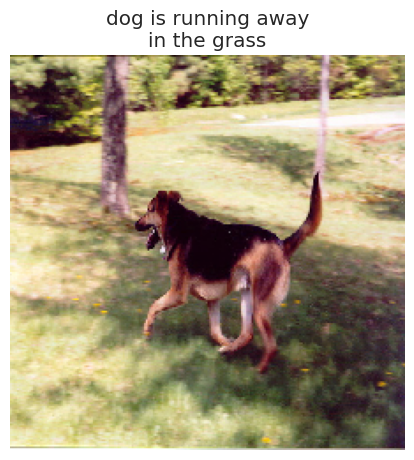

In [ ]:
display_one_images(full_max_sample)

In [ ]:
full_min_sample = Test_set.loc[Test_set["image"] == min_sample["image"]]
full_min_sample

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                    image  \
5765          5765          5765        5765  94232465_a135df2711.jpg   
5766          5766          5766        5766  94232465_a135df2711.jpg   
5767          5767          5767        5767  94232465_a135df2711.jpg   
5768          5768          5768        5768  94232465_a135df2711.jpg   
5769          5769          5769        5769  94232465_a135df2711.jpg   

                                                caption  \
5765       lady ice skates while pulling child in buggy   
5766  mother pulls her daughter in wagon over snowy ...   
5767  woman pulling wagon with girl in it across fro...   
5768  the girl pulls toddler in cart while skating o...   
5769  the woman is ice skating and pulling the littl...   

                                        new_caption  sim_score  
5765  man in blue shirt is riding bike on the beach     0.0582  
5766  man in blue shirt is riding bike on the beach     0.0063  
5767  man in blue shirt is riding bike on the beach     0.0912  
5768  man in blue shirt is riding bike on the beach    -0.0656  
5769  man in blue shirt is riding bike on the beach    -0.0630

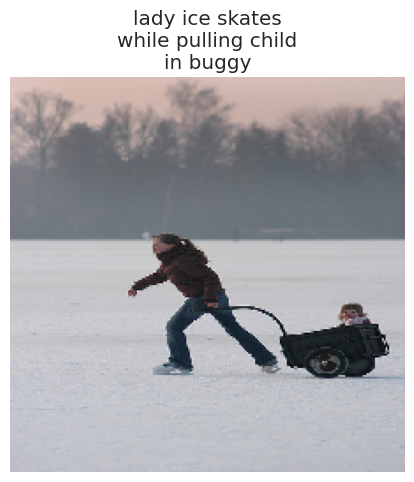

In [ ]:
display_one_images(full_min_sample)